# Importing Data From Google Drive

Originally, the [ASL Alphabet dataset](https://www.kaggle.com/grassknoted/asl-alphabet) was downloaded from Kaggle and stored as a zip file on google drive.

We take the following steps to access and unzip the data for our use.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install fastai
!pip install fastbook

In [3]:
from fastai.vision.all import *
from fastbook import *

In [ ]:
# Unzip the images on local disk
!unzip '/content/drive/My Drive/Fast AI/Datasets/asl.zip'

# Data Augmentation and Preprocessing

Once the data is unzipped, we can begin to apply transformations to augment it and view its distribution as well.

In [5]:
path = Path('/content/asl_alphabet_train/asl_alphabet_train')

In [6]:
asl = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                get_y = parent_label,
                item_tfms = RandomResizedCrop(200, min_scale=0.5),
                batch_tfms = aug_transforms(mult=2)
                )

In [7]:
# We load in our data by using a batch of 32 images at a time 
dls = asl.dataloaders(path, bs = 32)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [8]:
# The total of 87,000 images were categorized into training and validation sets using a 80-20 split
print(f"Number of training images: {len(dls.train_ds.items)}")
print(f"Number of validation images: {len(dls.valid_ds.items)}")

Number of training images: 69600
Number of validation images: 17400


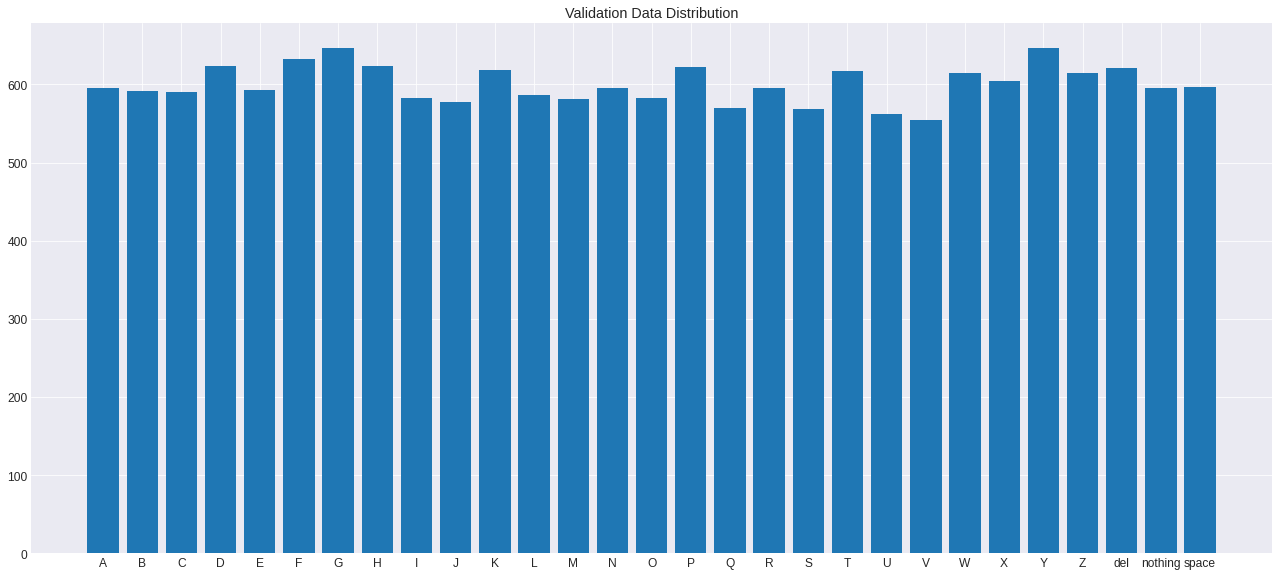

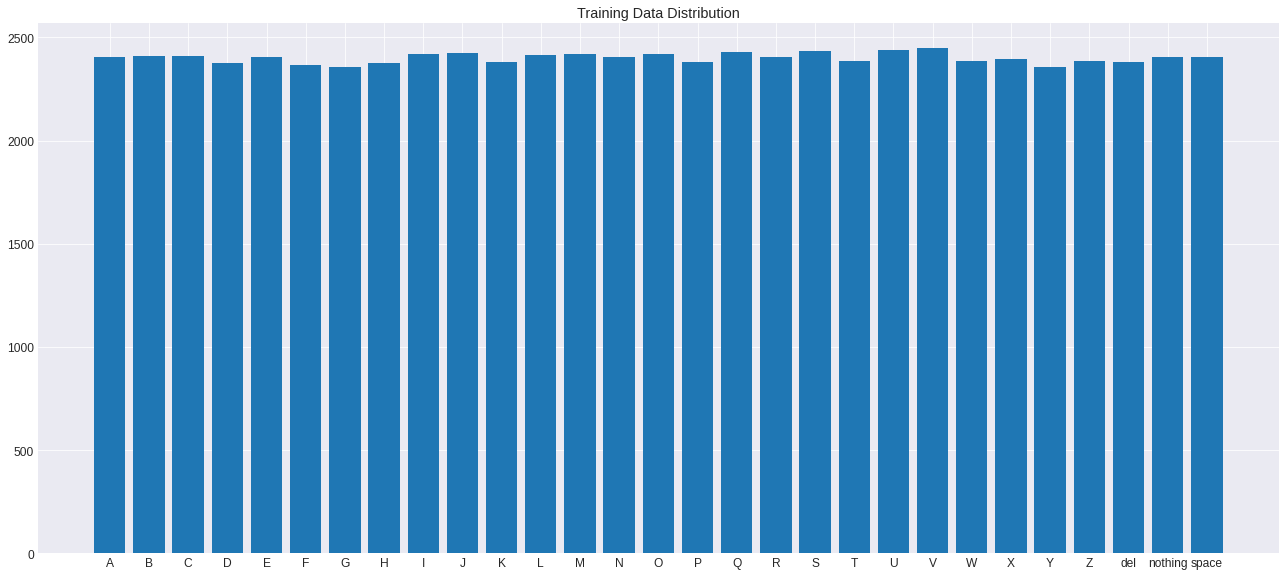

In [16]:
from collections import Counter

plt.style.use('seaborn-darkgrid')

def category_count(class_items, title):
  
  list_of_classes = [path.parts[-2] for path in class_items]
  d = dict(sorted(Counter(list_of_classes).items()))

  fig, ax = plt.subplots(figsize=(18,8))
  fig.tight_layout()

  plt.title(title)
  ax.bar(d.keys(), d.values())

category_count(dls.valid_ds.items, 'Validation Data Distribution')
category_count(dls.train_ds.items, 'Training Data Distribution')

The plots above show that the distribution of both our training and validation sets is pretty well-balanced.

# Visualizing Images

We can view how the transformations affect our images

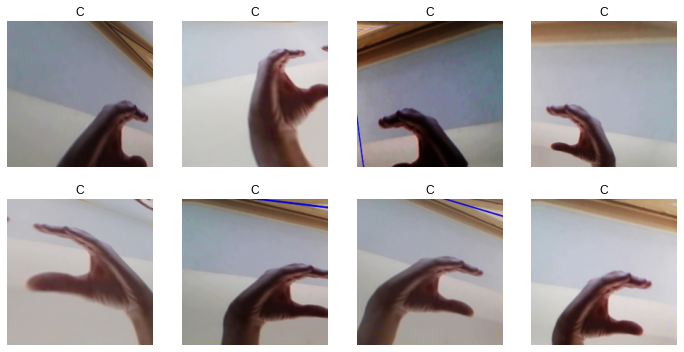

In [ ]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Generally, we can get a glimpse of our training and validation dataset by calling the show_batch command on our dataloader object

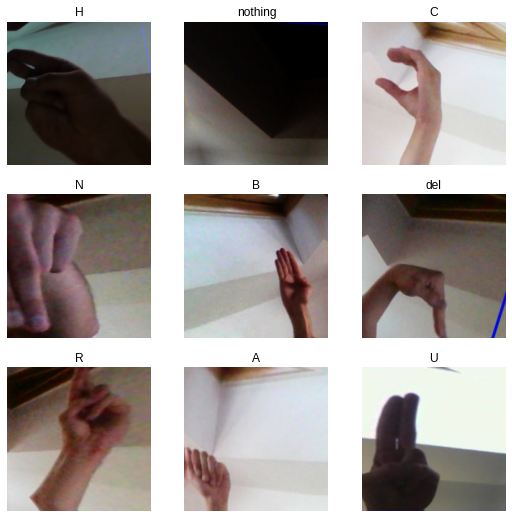

In [ ]:
dls.show_batch(max_n=9)

# Training the Model

We make use of Transfer Learning (using an existing, state-of-the-art, trained model) on our dataset. Here, we make use of the resnet34 model architecture which has been trained on the ImageNet dataset.

In [51]:
# Training the Model
learn = cnn_learner(dls, resnet34, metrics=accuracy).to_fp16()

In [53]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

We train the model for 2 epochs, meaning our model goes through the entire training set, one batch at a time, twice.

In [54]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.407059,0.031757,0.990690,18:58
1,0.247669,0.008119,0.997931,18:56
2,0.185062,0.003412,0.999253,18:56
3,0.164427,0.002392,0.999310,18:56


That the validation loss is so much lower than the training loss seems, at first glance, to be an error.
However, we note that the batch transformations are, by default, applied to the training images and not the validation images, making it tougher for the model to classifiy them. We can see this difference by viewing a sample of the validation images.

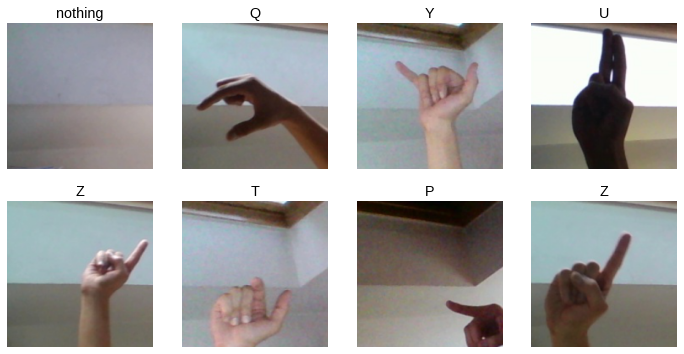

In [19]:
dls.valid.show_batch(max_n=8, nrows = 2)

Exporting and Loading the model

In [55]:
learn.export('/content/drive/My Drive/Fast AI/asl_model.pkl')

In [75]:
learner_inf = load_learner('/content/drive/My Drive/Fast AI/asl_model.pkl')

Making Predictions

In [104]:
test_dl = dls.test_dl(get_image_files_sorted('/content/asl_alphabet_test/asl_alphabet_test'))

In [77]:
preds, _ = learner_inf.get_preds(dl=test_dl)

In [86]:
print(preds[0].sum())
print(preds.shape) # 28 x 29 since test data has 28 image classes, so each row of preds gives the model's scores for each of the 29 classes in the training data

tensor(1.0000)
torch.Size([28, 29])


In [85]:
dls.vocab 
# 29 image classes in the training data set

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [80]:
y = torch.argmax(preds, dim=1)
cls_preds = list(map(lambda x: list(dls.vocab.o2i.keys())[list(dls.vocab.o2i.values()).index(x)], y))
print(cls_preds)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


In [94]:
# load in the paths of all test images
imgs = get_image_files_sorted('/content/asl_alphabet_test/asl_alphabet_test')

# extract the labels of each image
true_labels = [imgs[i].parts[-1].split('_')[0] for i in range(len(imgs))]

# compare model predictions with actual output
comp = [x == y for x,y in zip(cls_preds, true_labels)]

# if we sum up our comparison list, we total comes out as 28
# this means that all 28 of our predictions was correct
sum(comp)

28

Using custom images to test the model

In [95]:
w = widgets.FileUpload()
w

FileUpload(value={}, description='Upload')

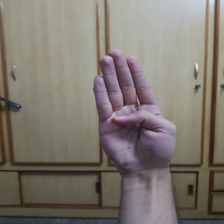

In [103]:
img = PILImage(PILImage.create(w.data[0]).resize((224,224)))
img

In [98]:
learner_inf.predict(img)

('B',
 tensor(1),
 tensor([1.3498e-06, 9.9364e-01, 2.2780e-09, 1.3572e-09, 8.4618e-04, 1.3571e-09, 2.5917e-09, 1.5473e-07, 6.5672e-07, 2.9810e-09, 2.8822e-09, 9.3481e-06, 4.1340e-07, 1.7346e-08, 6.4996e-09, 2.3771e-09,
         1.3817e-08, 9.3027e-07, 2.2389e-06, 7.3249e-04, 5.2068e-04, 1.2754e-06, 2.6466e-05, 1.7289e-05, 4.1399e-03, 1.1647e-07, 3.2987e-07, 3.2579e-06, 5.5063e-05]))